In [11]:
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.svm import SVC
import pydot

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

from IPython.display import display, HTML
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# Question I: Revisiting HW4 Bank Classication with New Tools (for dataset A) 

# I. Loading the dataset and performing data preprocessing

> Load a simple dataset and perform some basic data preprocessing to fill out ”unknowns”,
outliers or other invalid data. Explain what preprocessing was performed and why. Also,
change categorical data into numerical features using pandas.get dummies [5].

In [ ]:
bank_addidtional_full = "bank-additional.csv"

data = pd.read_csv(bank_addidtional_full, sep = ';', na_values=["unknown"])
df = pd.DataFrame(data)
df.head(10)

### We first check for missing values in the dataset. There was 1230 entries as unknown in the catogerical features that were replaced with NaN.

In [ ]:
print(df.isnull().sum().sum())
print(df.shape)
df.info()

# NaN values were replaced by the mode of the column

In [ ]:
df = df.fillna(df.mode().iloc[0])

In [ ]:
df.head(10)

### Then we convert all the catogrical columns to numerical columns. Also, dropping the duration column since is a predictive variable according to UCI website and should be dropped if the purpose is to build a realistic model

In [ ]:
print(df.shape)
df._get_numeric_data().head()
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df.drop(['duration'], axis=1, inplace=True)
df = pd.get_dummies(df,drop_first=True)
display(df.head(5))

In [ ]:
df.shape

In [ ]:
cols = list(df.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('y')) #Remove y from list
df = df[cols + ['y']] #Create new dataframe with columns in the order you want
display(df.head(5))

### According to UCI dataset description, the pdays columns (which represents the number of days passed by after the client was last contacted from a previous campaign) has some 999 values which means that client was not previously contacted. We replaced these 999 values with 0 since samples with 999 entries would be considered as an outliers when it comes to data cleaning. There was found to be 3,959 samples in the pdays column that had to be replaced with 0 instead of 999



In [ ]:
sns.boxplot(x=df['pdays'])
df['pdays'].value_counts()
# data['pdays'].isna().sum().sum()

In [ ]:
# df.pdays = df.pdays.replace({999: np.nan })
# display(df.pdays.describe())
# sns.boxplot(x=df['pdays'])

In [ ]:
# df.pdays = df.pdays.fillna(df.pdays.mean() + df.pdays.std()*6)
# sns.boxplot(x=df['pdays'])

### Now detecting the outliers and keeping samples that are only within 3 standard deviations

In [ ]:
# df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
# keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

In [ ]:
print(df.shape)
df.head()

In [ ]:
df['y'].value_counts()

In [ ]:
df.info()

In [ ]:
df.head(10)

# II. Dividing data into training and testing

Splitting the data into train and test data. The test data size chosen to be 30%.

In [ ]:
X = df.drop('y',axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,random_state=101)

In [ ]:
X_test.head()

# III. Applying classification: 

# a) Decision Tree

## First, the classifier was instantiated with the default parameters and then was tuned later for comparison

In [ ]:
dtree = DecisionTreeClassifier(random_state=101)
dtree.fit(X_train,y_train)

## Predicting and evaluating the model

In [ ]:
predictions = dtree.predict(X_test)
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

## ROC is plotted below to check for overfitting cases with depth of the tree

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()
#Source: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

Based on the graph above, we see that when we have a high tree depth we get an overfitting case where the model can predicts the train data perfectly (high area under curve), however, the models fails to generalize and predict new data (test data)

In [ ]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=5)

In [ ]:
dt_clf = clf_gini.fit(X_train, y_train)

In [ ]:
y_pred_dt = dt_clf.predict(X_test)

In [ ]:
print("Accuracy is ", accuracy_score(y_test,y_pred_dt)*100)
print(confusion_matrix(y_test,y_pred_dt))
print('\n')
print(classification_report(y_test,y_pred_dt))

In [ ]:
# min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
# train_results = []
# test_results = []
# for min_samples_split in min_samples_splits:
#    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
#    dt.fit(X_train, y_train)
#    train_pred = dt.predict(X_train)
#    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    train_results.append(roc_auc)
#    y_pred = dt.predict(X_test)
#    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    test_results.append(roc_auc)
# from matplotlib.legend_handler import HandlerLine2D
# line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
# line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel('AUC score')
# plt.xlabel('min samples split')
# plt.show()

In [ ]:
# min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
# train_results = []
# test_results = []
# for min_samples_leaf in min_samples_leafs:
#    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
#    dt.fit(X_train, y_train)
#    train_pred = dt.predict(X_train)
#    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    train_results.append(roc_auc)
#    y_pred = dt.predict(X_test)
#    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#    roc_auc = auc(false_positive_rate, true_positive_rate)
#    test_results.append(roc_auc)
# from matplotlib.legend_handler import HandlerLine2D
# line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
# line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
# plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel('AUC score')
# plt.xlabel('min samples leaf')
# plt.show()

## Tree Visualization using the the built-in visualization from Scikit learn. This requires to install the pydot library and Graphviz.

In [ ]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list(X_train.columns)

In [ ]:
dot_data = StringIO()  
export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png()) 

# b) Random Forests (RF)

We will first fit the model with default parameters and evaluate the performance, then we will tune the parameters and compare the performance. 

In [ ]:
rfc = RandomForestClassifier(random_state=101)
rfc_clf = rfc.fit(X_train, y_train)

In [ ]:
rfc_pred = rfc_clf.predict(X_test)

In [ ]:
print("Accuracy is ", accuracy_score(y_test,rfc_pred)*100)
print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred))

Similar to DT classifier, we will use the area under curve AUC to evaluate the model. 

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1, random_state=101)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

    
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()
# Source: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

The n_estimators in the random forests classifier represents the numsber of trees used in the classifier. Based on the AUC graph above, we see that the highest AUC score for the test data will be around 16 n_estimators. Increasing the n_estimators decreases the test perfomance. 

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, random_state=101)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()
#Source: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

We see that the higher the tree depth, we get an overfitting case. So a tree depth of 3 wil be chosen

In [ ]:
RFC = RandomForestClassifier(n_estimators=16,random_state=101, max_depth=3)
RFC_clf = RFC.fit(X_train, y_train)
RFC_pred = RFC.predict(X_test)


print("Results from the default parameters:")
print("Accuracy is ", accuracy_score(y_test,rfc_pred)*100)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))
print('\n')
print("Results from the tunned parameters:")
print("Accuracy is ", accuracy_score(y_test,RFC_pred)*100)
print(confusion_matrix(y_test,RFC_pred))
print(classification_report(y_test,RFC_pred))

# C) Neural Networks (NN)

Data should be normalized before training the neural network model. This is because the NN model might not converge before the max number of iterations allowed. Also, the multi-layer perception is sensitive to scaling the features. (source: https://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2)



In [ ]:
scaler = StandardScaler()
scaler.fit(df.drop('y',axis=1))
scaled_features = scaler.transform(df.drop('y',axis=1))

df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])

X_nn = df_feat.loc[:,]
y_nn = df['y']
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn,y_nn, test_size=0.30,random_state=101)


In [ ]:
y_nn.head()

In [ ]:
# Testing with 2 layers with number of neurons:(36,36)
mlp = MLPClassifier(max_iter=1000,random_state=101, hidden_layer_sizes=(36,36))

In [ ]:
nn_clf = mlp.fit(X_train_nn,y_train_nn)

predicting and evaluating

In [ ]:
predictions = nn_clf.predict(X_test_nn)

In [ ]:
print("Accuracy is ", accuracy_score(y_test,predictions)*100)
print(confusion_matrix(y_test,predictions))
print("\n")
print(classification_report(y_test,predictions))

Tunning the NN parameters using the GridSearchCV method.

In [ ]:
parameter_space = {
    'max_iter': [2000],
    'hidden_layer_sizes': [(32,32), (20,20), (47,47)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant'],
    'random_state': [101]
}

In [ ]:
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3, refit=True)

In [ ]:
clf.fit(X_train_nn, y_train_nn)

In [ ]:
# Best parameter set
print('Best parameters found:\n', clf.best_params_)

In [ ]:
mlp_nn = MLPClassifier(activation = 'tanh',alpha = 0.0001, learning_rate= 'constant', solver = 'sgd', random_state=101, hidden_layer_sizes=(32,32), max_iter=2000)

In [ ]:
mlp_nn.fit(X_train_nn, y_train_nn)

In [ ]:
y_true, y_pred = y_test_nn , clf.predict(X_test_nn)

print("Results from the default parameters:")
print("Accuracy is ", accuracy_score(y_test,predictions)*100)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print("\n")
print("Results from the tunned parameters:")
print("Accuracy is ", accuracy_score(y_true,y_pred)*100)
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true, y_pred))


# IV. Creating plots of the models on the test data

# Plotting best two features

Normalized Data for Nural Network:

In [ ]:
X_testnn_df =pd.DataFrame(X_test_nn, columns=df.columns[:-1]) 
y_testnn_df = pd.DataFrame(y_test_nn, columns = ['y'])
X_testnn_df.head()

In [ ]:
X_test_df =pd.DataFrame(X_test, columns=df.columns[:-1]) 
y_test_df = pd.DataFrame(y_test, columns = ['y'])
X_test_df.head()

In [ ]:
list(zip(X_test_df.columns, dt_clf.feature_importances_))

In [ ]:
X = X_test_df.iloc[:, ]
X = X[['pdays','nr.employed']]
y= y_test_df['y']



label = ['Decision Tree', 'Random Forests']
clf_list = [clf_gini, RFC]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

X = X.values
y = y.values

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)
    plt.xlabel('pdays')
    plt.ylabel('nr.employed')

plt.show()

In [ ]:
X = X_testnn_df.iloc[:, ]
X = X[['pdays','nr.employed']]
y= y_testnn_df['y']


label = ['Neural Network']
clf_list = [mlp_nn]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

X = X.values
y = y.values


for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)
    plt.xlabel('pdays')
    plt.ylabel('nr.employed')

    
plt.show()

In [ ]:
X = X_test_df.iloc[:, ]
X = X[['nr.employed','euribor3m']]
y= y_test_df['y']



label = ['Decision Tree', 'Random Forests']
clf_list = [clf_gini, RFC]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

X = X.values
y = y.values

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)
    plt.xlabel('nr.employed')
    plt.ylabel('euribor3m')

plt.show()

In [ ]:
X = X_testnn_df.iloc[:, ]
X = X[['nr.employed','euribor3m']]
y= y_testnn_df['y']


label = ['Neural Network']
clf_list = [mlp_nn]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

X = X.values
y = y.values


for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)
    plt.xlabel('nr.employed')
    plt.ylabel('euribor3m')

    
plt.show()

In [ ]:
X = X_test_df.iloc[:, ]
X = X[['pdays','euribor3m']]
y= y_test_df['y']


label = ['Decision Tree', 'Random Forests']
clf_list = [clf_gini, RFC]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

X = X.values
y = y.values


for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)
    plt.xlabel('pdays')
    plt.ylabel('euribor3m')

plt.show()

In [ ]:
X = X_testnn_df.iloc[:, ]
X = X[['pdays','euribor3m']]
y= y_testnn_df['y']


label = ['Neural Network']
clf_list = [mlp_nn]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

X = X.values
y = y.values


for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)
    plt.xlabel('pdays')
    plt.ylabel('euribor3m')

    
plt.show()

# Produce a table with the true/false positive/negative metrics as well as accuracies

In [ ]:
print("Classification Report for Decision Tree:")
print("Accuracy is ", accuracy_score(y_test,y_pred_dt)*100)
print(confusion_matrix(y_test,y_pred_dt))
print('\n')
print(classification_report(y_test,y_pred_dt))

print("Classification Report for Random Forests:")
print("Accuracy is ", accuracy_score(y_test,RFC_pred)*100)
print(confusion_matrix(y_test,RFC_pred))
print(classification_report(y_test,RFC_pred))


print("Classification Report for Neural Network:")
print("Accuracy is ", accuracy_score(y_true,y_pred)*100)
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true, y_pred))

In [ ]:
algorithms = ('Decision Tree', 'Random Forest', 'Neural Network')
ind = ['Accuracies (%)', 'True Positive', 'False Positive', 'False Negative', 'True Negative']
accuracies = [accuracy_score(y_test,y_pred_dt)*100,accuracy_score(y_test,RFC_pred)*100,accuracy_score(y_true,y_pred)*100]
true_negative = [confusion_matrix(y_test,y_pred_dt)[0][0], confusion_matrix(y_test,RFC_pred)[0][0],confusion_matrix(y_true,y_pred)[0][0]]
false_negative = [confusion_matrix(y_test,y_pred_dt)[0][1],confusion_matrix(y_test,RFC_pred)[0][1], confusion_matrix(y_true,y_pred)[0][1]]
false_positive = [confusion_matrix(y_test,y_pred_dt)[1][0],confusion_matrix(y_test,RFC_pred)[1][0],confusion_matrix(y_true,y_pred)[1][0]]
true_positive = [confusion_matrix(y_test,y_pred_dt)[1][1],confusion_matrix(y_test,RFC_pred)[1][1],confusion_matrix(y_true,y_pred)[1][1]]

arr1 = np.array([accuracies, true_positive,false_positive,false_negative,true_negative]) 
table_1 = pd.DataFrame(arr1, index = ind, columns = algorithms)

table_1

In [ ]:
# import matplotlib.pyplot as plt; plt.rcdefaults()

algorithms = ('Decision Tree', 'Random Forest', 'Neural Network')
x_axis = np.arange(len(algorithms))
dt_accuracy = accuracy_score(y_test,y_pred_dt)*100
rf_accuracy = accuracy_score(y_test,RFC_pred)*100
nn_accuracy = accuracy_score(y_true,y_pred)*100
performance = [dt_accuracy,rf_accuracy,nn_accuracy]
 
plt.bar(x_axis, performance, align='center', alpha=0.5)
plt.xticks(x_axis, algorithms)
plt.ylabel('Accuracy')
plt.title('Accuracies for the Classification Algorithms')
 

plt.show()

In [ ]:
algorithms = ('Decision Tree', 'Random Forest', 'Neural Network')
x_axis = np.arange(len(algorithms))
dt_truep = confusion_matrix(y_test,y_pred_dt)[0][0]
rf_truep = confusion_matrix(y_test,RFC_pred)[0][0]
nn_truep = confusion_matrix(y_true,y_pred)[0][0]
truep = [dt_truep,rf_truep,nn_truep]
 
plt.bar(x_axis, truep, align='center', alpha=0.5)
plt.xticks(x_axis, algorithms)
plt.ylabel('True negative')
plt.title('True negative values')
 

plt.show()

In [ ]:
algorithms = ('Decision Tree', 'Random Forest', 'Neural Network')
x_axis = np.arange(len(algorithms))
dt_falsep = confusion_matrix(y_test,y_pred_dt)[0][1]
rf_falsep = confusion_matrix(y_test,RFC_pred)[0][1]
nn_falsep = confusion_matrix(y_true,y_pred)[0][1]
falsep = [dt_falsep,rf_falsep,nn_falsep]
 
plt.bar(x_axis, falsep, align='center', alpha=0.5)
plt.xticks(x_axis, algorithms)
plt.ylabel('False Negative')
plt.title('False negative values for the classificiation algorithms')
 

plt.show()

In [ ]:
algorithms = ('Decision Tree', 'Random Forest', 'Neural Network')
x_axis = np.arange(len(algorithms))
dt_falseN = confusion_matrix(y_test,y_pred_dt)[1][0]
rf_falseN = confusion_matrix(y_test,RFC_pred)[1][0]
nn_falseN = confusion_matrix(y_true,y_pred)[1][0]
falseN = [dt_falseN,rf_falseN,nn_falseN]
 
plt.bar(x_axis, falseN, align='center', alpha=0.5)
plt.xticks(x_axis, algorithms)
plt.ylabel('False Positive')
plt.title('False positive values for the classificiation algorithms')
 

plt.show()

In [ ]:
algorithms = ('Decision Tree', 'Random Forest', 'Neural Network')
x_axis = np.arange(len(algorithms))
dt_falseP = confusion_matrix(y_test,y_pred_dt)[1][1]
rf_falseP = confusion_matrix(y_test,RFC_pred)[1][1]
nn_falseP = confusion_matrix(y_true,y_pred)[1][1]
falseP = [dt_falseP,rf_falseP,nn_falseP]
 
plt.bar(x_axis, falseP, align='center', alpha=0.5)
plt.xticks(x_axis, algorithms)
plt.ylabel('True Postive')
plt.title('True postive values for the classificiation algorithms')
 

plt.show()

# Question 2: Parameter Selection and Classification (for dataset B)

# 1. Data loading and preprocessing using the Z-score normalization 

In [5]:
dataB = pd.read_csv('DataDNA.csv', sep = ',', header= None)
df2 = pd.DataFrame(dataB)
print(df2.shape)
df2.head(10)

(2200, 58)


,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,1,2,1,2,1,2,3,3,3,3,...,3,2,3,4,2,2,2,2,1,1
1,3,3,4,2,1,2,2,4,3,2,...,1,4,3,4,4,4,1,3,4,1
2,4,1,4,4,4,4,1,1,2,1,...,1,2,1,1,4,2,2,4,4,1
3,1,4,1,1,3,3,4,4,3,4,...,1,3,3,4,1,3,3,4,2,-1
4,3,4,4,3,1,1,4,4,4,1,...,3,1,3,2,1,4,2,1,1,-1
5,3,2,3,1,2,3,4,3,1,4,...,2,2,2,3,4,2,2,2,2,-1
6,4,2,1,4,2,4,4,4,2,3,...,4,3,3,4,2,2,1,2,4,1
7,3,3,4,3,1,3,4,3,4,1,...,4,2,2,1,1,4,3,3,1,1
8,1,3,4,3,3,1,1,4,2,1,...,2,1,3,2,2,2,2,1,1,1
9,1,3,1,1,3,1,1,2,1,1,...,2,4,2,2,2,1,1,3,1,1


In [6]:
print(df2.isnull().sum().sum())
# df2.iloc[:,:-1].head()
print(df2.shape)
df2.head()

0
(2200, 58)


,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,1,2,1,2,1,2,3,3,3,3,...,3,2,3,4,2,2,2,2,1,1
1,3,3,4,2,1,2,2,4,3,2,...,1,4,3,4,4,4,1,3,4,1
2,4,1,4,4,4,4,1,1,2,1,...,1,2,1,1,4,2,2,4,4,1
3,1,4,1,1,3,3,4,4,3,4,...,1,3,3,4,1,3,3,4,2,-1
4,3,4,4,3,1,1,4,4,4,1,...,3,1,3,2,1,4,2,1,1,-1


In [7]:
df2[57].value_counts()

 1    1137
-1    1063
Name: 57, dtype: int64

In [8]:
# df2[57] = df2[57].map({1: 1, -1: 0})

In [9]:
df2[57].head()

0    1
1    1
2    1
3   -1
4   -1
Name: 57, dtype: int64

In [13]:
# # Z-score normalized values
normalized_df = df2.iloc[:,:-1]
std_scale = preprocessing.StandardScaler().fit(normalized_df)
df_std = std_scale.transform(normalized_df)
df_zscore = pd.DataFrame(df_std)
df_zscore.columns =  normalized_df.columns
df_zscore.head()

/home/engineer/anaconda3/envs/ece657A/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/engineer/anaconda3/envs/ece657A/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56
0,-1.352898,-0.487479,-1.372441,-0.470994,-1.431156,-0.448281,0.405564,0.415676,0.396645,0.392611,-1.454242,-0.500168,-1.369434,0.381451,1.253160,-0.579766,-1.471189,-0.599369,-0.583351,-0.598913,-1.437523,-1.477642,-0.611451,0.332324,-1.495711,1.418861,-0.570943,0.015762,-1.448819,1.821169,-0.776737,-0.237862,-1.131068,1.535688,-0.569710,-0.376354,-1.395430,-0.483853,-1.401924,-1.399702,-0.496609,-0.455196,-1.402111,1.391803,-0.432450,0.472744,0.497988,1.424712,0.453914,-0.464630,0.513026,1.383572,-0.452656,-0.400135,-0.458416,-0.417566,-1.392249
1,0.459203,0.433082,1.360021,-0.470994,-1.431156,-0.448281,-0.495689,1.322008,0.396645,-0.509943,-0.530114,-0.500168,-1.369434,-0.549950,1.253160,1.232002,0.325434,-0.599369,-1.475822,-0.598913,-1.437523,0.346607,0.307396,-1.488629,-0.600319,0.496979,0.392304,1.749605,-0.318134,-1.360333,0.082831,0.675396,-1.131068,-1.391967,0.324910,-1.292259,1.360356,-0.483853,-0.477671,1.376149,-0.496609,-1.391112,-1.402111,-1.357643,0.493928,0.472744,0.497988,0.490475,-1.356803,1.404083,0.513026,1.383572,1.424521,1.435731,-1.374415,0.497419,1.369651
2,1.365253,-1.408039,1.360021,1.317075,1.342890,1.371309,-1.396943,-1.396986,-0.491065,-1.412496,1.318143,-0.500168,-0.476237,-1.481351,0.343575,1.232002,-0.572878,-0.599369,-0.583351,-1.505108,-1.437523,-1.477642,-1.530297,-1.488629,0.295072,-1.346787,1.355552,0.882684,-1.448819,-1.360333,0.082831,1.588655,0.627483,0.559803,1.219529,-0.376354,-1.395430,-1.404680,-0.477671,1.376149,1.367795,-1.391112,-0.485426,-1.357643,-1.358828,-1.361537,1.414020,-1.378000,-1.356803,-0.464630,-1.316240,-1.376046,1.424521,-0.400135,-0.458416,1.412405,1.369651
3,-1.352898,1.353642,-1.372441,-1.365028,0.418208,0.461514,1.306817,1.322008,0.396645,1.295164,-0.530114,0.400298,1.310158,-0.549950,-0.566010,0.326118,0.325434,0.311904,0.309119,1.213478,0.364500,1.258732,-0.611451,0.332324,0.295072,1.418861,1.355552,-0.851159,-0.318134,-0.299832,-1.636305,-1.151121,1.506759,0.559803,-1.464329,1.455456,1.360356,1.357802,1.370835,1.376149,-1.428812,-1.391112,1.347943,-1.357643,-1.358828,1.389885,-0.418044,-0.443763,-1.356803,0.469726,0.513026,1.383572,-1.391244,0.517798,0.457583,1.412405,-0.471615
4,0.459203,1.353642,1.360021,0.423041,-1.431156,-1.358075,1.306817,1.322008,1.284354,-1.412496,-1.454242,0.400298,1.310158,1.312852,1.253160,0.326118,-1.471189,0.311904,-1.475822,1.213478,1.265512,1.258732,0.307396,1.242800,1.190464,1.418861,0.392304,-0.851159,-0.318134,-0.299832,-1.636305,-1.151121,1.506759,-1.391967,-1.464329,0.539551,-1.395430,1.357802,1.370835,-0.474418,0.435593,0.480721,-1.402111,-1.357643,-1.358828,0.472744,-0.418044,1.424712,0.453914,-1.398986,0.513026,-0.456173,-1.391244,1.435731,-0.458416,-1.332552,-1.392249


# 2.Parameter Selection: 

# a) K-NN

For k= 1, Accuracies: [0.69902913 0.69480519 0.69155844 0.72077922 0.72312704]
For k= 3, Accuracies: [0.70226537 0.73376623 0.70779221 0.73701299 0.71661238]
For k= 5, Accuracies: [0.72815534 0.73376623 0.75       0.72402597 0.71009772]
For k= 7, Accuracies: [0.73786408 0.74675325 0.72727273 0.73051948 0.70032573]
For k= 31, Accuracies: [0.69902913 0.74350649 0.70454545 0.73376623 0.71009772]


Mean of accuracy scores: [0.7058598038374136, 0.7194898357179752, 0.729209053493548, 0.728547053022876, 0.7181890055802962]


Length of list 5
Max of list 0.729209053493548


Text(0, 0.5, 'Cross-validated accuracy')

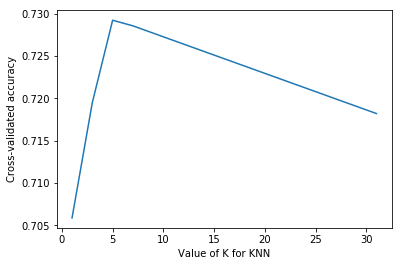

In [14]:
X = df_zscore.loc[:,]
y = df2[57]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,random_state=42)

# 5-fold cross-validation with k = [1, 3, 5, 7, 31] for KNN (the n_neighbors parameter)
k = [1, 3, 5, 7, 31]
k_scores = []

for i in k:
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
    print("For k= {}, Accuracies: {}".format(i, scores))
    

print('\n')
print('Mean of accuracy scores:', k_scores)
print('\n')
print('Length of list', len(k_scores))
print('Max of list', max(k_scores))

plt.plot(k, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

#ref: https://www.ritchieng.com/machine-learning-cross-validation/

# b) SVM (RBF Kernel)

In [ ]:
# # 5-fold cross-validation for SVM
# c = [0.1, 0.5, 1, 2, 5,10, 20, 50]
# sigma = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
# svm_scores = []

# for i,j in zip(c,sigma):
#     svm_clf = SVC(kernel='rbf',C = i, gamma=j)
#     scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy')
#     svm_scores.append(scores.mean())
# #     print("scores = {}".format(scores))
# #     print("Maan scores = {}".format(scores.mean()))
    

# print('\n')
# print('Mean of accuracy scores:', svm_scores)
# print('\n')
# print('Length of list', len(svm_scores))
# print('Max of list', max(svm_scores))

# plt.plot(k, k_scores)
# plt.xlabel('Value of K for KNN')
# plt.ylabel('Cross-validated accuracy')


In [15]:
model = SVC()
param_grid = {'C': [0.1, 0.5, 1, 2, 5,10, 20, 50], 'gamma': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}
grid = GridSearchCV(SVC(kernel='rbf'),param_grid,cv=5,refit=True)
grid.fit(X_train,y_train)
grid.best_params_

{'C': 10, 'gamma': 0.01}

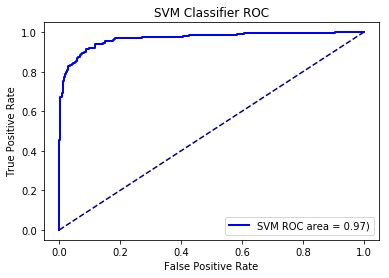

In [27]:
#SVM GATHER DATA
rbf_svc = SVC(kernel='rbf', gamma=0.01, C=10,probability=True).fit(X_train,y_train)

#PREDICT PROBABILITY SCORE = 2D ARRAY FOR EACH PREDICTION
predictedprobSVC = rbf_svc.predict_proba(X_test)

#GET ROC DATA
fpr, tpr, thresholds = roc_curve(y_test, predictedprobSVC[:,1])
roc_auc = auc(fpr, tpr)

#GRAPH DATA
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#plt.xlim([0.0, 1.0]
#plt.ylim([0.0, 1.05])
plt.title('SVM Classifier ROC')
plt.plot(fpr, tpr, color='blue', lw=2, label='SVM ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

#ref :https://medium.com/datadriveninvestor/computing-an-roc-graph-with-python-a3aa20b9a3fb